In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline


## Building the Value Class

In [2]:
class Value: 
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op


    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __neg__(self): 
        return self * -1
    
    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward(): 
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self): 
        x = self.data 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): 
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self): 

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go one variable at a time and apply the chain rule
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format=format, 
                  graph_attr={
                      'rankdir': rankdir,
                      'bgcolor': '#ffffff',  # White background
                      'ratio': 'expand',
                      'width': '100',
                      'height': '50',
                      'margin': '0.1',
                      'nodesep': '0.5',     # Increased space between nodes
                      'ranksep': '0.5'      # Increased rank separation
                  })
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        # Get the variable name if it exists in locals/globals
        var_name = None
        for name, value in globals().items():
            if value is n:
                var_name = name
                break
        if var_name is None:
            for name, value in locals().items():
                if value is n:
                    var_name = name
                    break
        
        # Enhanced node formatting
        label = f"""{{
            {var_name if var_name else ''}
            |data: {n.data:.4f}
            |grad: {n.grad:.4f}
        }}"""
        
        dot.node(name=uid, 
                label=label, 
                shape='record',
                style='filled',
                fillcolor='#e8f3ff',  # Light blue background
                color='#2878b5',      # Darker blue border
                fontname='Arial',
                fontsize='12')
        
        if n._op:
            # Operation node styling
            dot.node(name=uid + n._op, 
                    label=n._op,
                    shape='circle',
                    style='filled',
                    fillcolor='#ff9999',  # Light red for operations
                    color='#cc4444',      # Darker red border
                    fontname='Arial Bold',
                    fontsize='12',
                    width='0.5',
                    height='0.5')
            dot.edge(uid + n._op, uid, color='#666666')
    
    # Edge styling
    for n1, n2 in edges:
        dot.edge(str(id(n1)), 
                str(id(n2)) + n2._op, 
                color='#666666',
                penwidth='1.5')
    
    return dot


In [3]:
a = Value(2.0)
b = Value(3.0)

c = b + a
print(f"c.data: {c.data}")  # Should be 5.0

d = c ** 2
print(f"d.data: {d.data}")  # Should be 25.0

e = d * 2
print(f"e.data: {e.data}")  # Should be 50.0

f = e**2 + 5 

print(f"f.data: {f.data}")  # Should be 25005

g = f * f 

print(f"g.data: {g.data}")  # Should be 65025

h = g * 2 - 3

print(f"h.data: {h.data}")  # Should be 4228250622

h.backward()

print("\nGradients:")
print(f"h.grad: {h.grad}")
print(f"g.grad: {g.grad}")
print(f"f.grad: {f.grad}")
print(f"e.grad: {e.grad}")
print(f"d.grad: {d.grad}")
print(f"c.grad: {c.grad}")
print(f"b.grad: {b.grad}")
print(f"a.grad: {a.grad}")

c.data: 5.0
d.data: 25.0
e.data: 50.0
f.data: 2505.0
g.data: 6275025.0
h.data: 12550047.0

Gradients:
h.grad: 1.0
g.grad: 2.0
f.grad: 10020.0
e.grad: 1002000.0
d.grad: 2004000.0
c.grad: 20040000.0
b.grad: 20040000.0
a.grad: 20040000.0


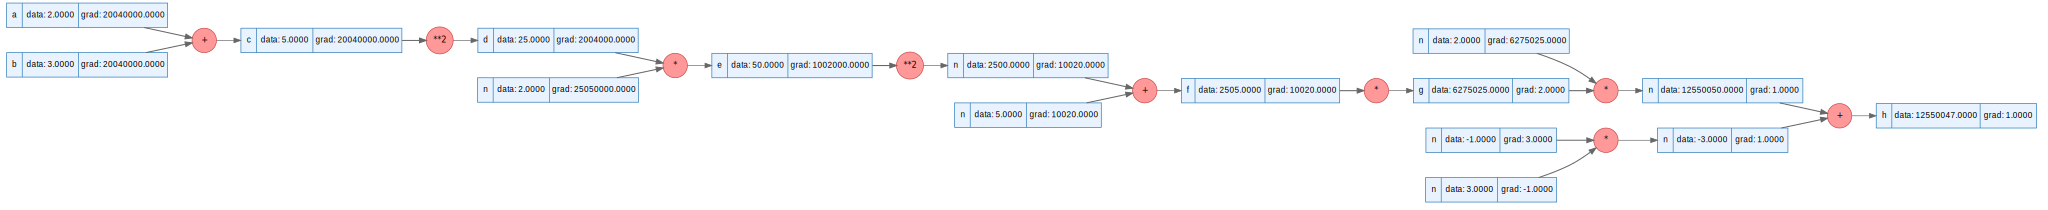

In [4]:
draw_dot(h)

In [5]:
## For Drawing...

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format=format, 
                  graph_attr={
                      'rankdir': rankdir,
                      'bgcolor': '#ffffff',  # White background
                      'ratio': 'expand',
                      'width': '100',
                      'height': '50',
                      'margin': '0.1',
                      'nodesep': '0.5',     # Increased space between nodes
                      'ranksep': '0.5'      # Increased rank separation
                  })
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        # Get the variable name if it exists in locals/globals
        var_name = None
        for name, value in globals().items():
            if value is n:
                var_name = name
                break
        if var_name is None:
            for name, value in locals().items():
                if value is n:
                    var_name = name
                    break
        
        # Enhanced node formatting
        label = f"""{{
            {var_name if var_name else ''}
            |data: {n.data:.4f}
            |grad: {n.grad:.4f}
        }}"""
        
        dot.node(name=uid, 
                label=label, 
                shape='record',
                style='filled',
                fillcolor='#e8f3ff',  # Light blue background
                color='#2878b5',      # Darker blue border
                fontname='Arial',
                fontsize='12')
        
        if n._op:
            # Operation node styling
            dot.node(name=uid + n._op, 
                    label=n._op,
                    shape='circle',
                    style='filled',
                    fillcolor='#ff9999',  # Light red for operations
                    color='#cc4444',      # Darker red border
                    fontname='Arial Bold',
                    fontsize='12',
                    width='0.5',
                    height='0.5')
            dot.edge(uid + n._op, uid, color='#666666')
    
    # Edge styling
    for n1, n2 in edges:
        dot.edge(str(id(n1)), 
                str(id(n2)) + n2._op, 
                color='#666666',
                penwidth='1.5')
    
    return dot

## Neural Network Definition


In [ ]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin: int, activation: Callable = None):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        self.activation = activation
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act if self.activation is None else self.activation(act)
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self, nin: int, nout: int, activation: Callable = None):
        self.neurons = [Neuron(nin, activation) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP(Module):
    def __init__(self, nin: int, nouts: List[int], activation: Callable = None):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

class Optimizer:
    def __init__(self, parameters):
        self.parameters = parameters
        
class SGD(Optimizer):
    def __init__(self, parameters, lr=0.01):
        super().__init__(parameters)
        self.lr = lr
    
    def step(self):
        for p in self.parameters:
            p.data -= self.lr * p.grad

class Adam(Optimizer):
    def __init__(self, parameters, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        super().__init__(parameters)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.m = [0.0 for _ in parameters]  # First moment
        self.v = [0.0 for _ in parameters]  # Second moment
        self.t = 0  # Timestep
    
    def step(self):
        self.t += 1
        b1, b2 = self.betas
        
        for i, p in enumerate(self.parameters):
            g = p.grad
            self.m[i] = b1 * self.m[i] + (1 - b1) * g
            self.v[i] = b2 * self.v[i] + (1 - b2) * g * g
            
            # Bias correction
            m_hat = self.m[i] / (1 - b1**self.t)
            v_hat = self.v[i] / (1 - b2**self.t)
            
            p.data -= self.lr * m_hat / (math.sqrt(v_hat) + self.eps)


class NeuralNetwork:
    def __init__(self, nin: int, architecture: List[int], activation: Callable = None):
        self.model = MLP(nin, architecture, activation)
        self.optimizer = None
        self.last_output = None  # Add this to track the last output
    
    def forward(self, x):
        out = self.model(x)
        self.last_output = out  # Store the output
        return out
    
    def backward(self):
        if self.last_output is None:
            raise ValueError("No forward pass performed yet")
        self.last_output.backward()
    
    def zero_grad(self):
        self.model.zero_grad()
    
    def set_optimizer(self, optimizer_name='adam', **kwargs):
        if optimizer_name.lower() == 'adam':
            self.optimizer = Adam(self.model.parameters(), **kwargs)
        elif optimizer_name.lower() == 'sgd':
            self.optimizer = SGD(self.model.parameters(), **kwargs)
    
    def step(self):
        if self.optimizer is None:
            raise ValueError("No optimizer set. Call set_optimizer() first.")
        self.optimizer.step()

## Example Usage

In [ ]:
#Create a minimal neural network: 2 inputs -> 1 output
nn = NeuralNetwork(2, [1], activation=lambda x: x.tanh())

    # Single training example
X = [[2.0, 0.0]]  # Just one input
y = [1.0]        # Target output

    # Set optimizer
nn.set_optimizer('adam', lr=0.1)

    # Single forward and backward pass
x = [Value(x) for x in X[0]]
    
    # Forward pass
pred = nn.forward(x)
loss = (pred - Value(y[0]))**2
nn.last_output = loss
    
    # Backward pass
nn.zero_grad()
loss.backward()
    
    # Visualize before optimization step
print(f'Prediction: {pred.data:.4f}')
print(f'Loss: {loss.data:.4f}')
dot = draw_dot(loss)
dot.render('simple_network', 
              format='svg',
              cleanup=True,
              view=True)